# Ising Model exploration

The actual Ising model Hamiltonian is
$$H_\mathrm{model}[\boldsymbol{S}^i] = - \sum_{j=1}^L \sum_{k=1}^L J_{j,k}S_{j}^iS_{k}^i = - \sum_{j=1}^L \sum_{k=1}^L S_{j}^iS_{k}^i J_{j,k}.$$

Following Mehta et al., we recast this model in the form
$$
H_\mathrm{model}^i \equiv \mathbf{X}^i \cdot \mathbf{J},
$$

where the vectors $\mathbf{X}^i$ represent all two-body interactions $\{S_{j}^iS_{k}^i \}$ with indices $j,k$ ranging from 1 to $L$ (the size of the array), and the index $i$ runs over the input configuration states in the data set.

Our goal will be to learn the interaction strength ${\bf J}$.

## Prepare training data

First we create the datasets. We do this by using our knowledge of the Ising model to calculate the correct energy of each state. If we were doing this experimentally, we would measure the energy of each configuration instead of simply calculating it.

Actually, we're going to start with a really small example dataset and return later to a larger physical dataset.

In [4]:
import numpy as np
np.random.seed(100)

### Ising model size
L=20

# create 1 random 1-d Ising state configurations
states=np.random.choice([-1, 1], size=(1,L))

def ising_energies(states):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    L = states.shape[1]
    J = np.zeros((L, L),)
    for i in range(L):
        J[i,(i+1)%L]=-1.0 # interaction between nearest-neighbors

    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states)

It is always a good idea to check the dataset yourself.
You will get some idea of the range of data values, the shape of the input vector, and the Python data type.

In [5]:
print(len(states), "states =", states)
print(len(energies), "energies = ", energies)

1 states = [[-1 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1]]
1 energies =  [-4.]


The next part is a bit tricky. We are trying to compute all of the interactions between different spin locations, not just the nearest neighbors. In other words, we're trying to write out $S_j S_k$ for all $j,k$ pairs. This means we will end up with a matrix of size $L \times L$.

Formally, this is the same as computing the outer product of the `states` vector with itself.
If you write the states vector as ${\bf S}$, then this is constructing ${\bf S}{\bf S}^T \equiv {\bf X}$.
There are several ways to do this: the most transparent way is to iterate over $j$ and $k$, and the most compact way is to use the NumPy `einsum` format.

Then we flatten the $L \times L$ array of interactions into a $1 \times L^2$ array called `flattened_states`.
As we have seen in the past, it is straightforward to create a Torch tensor from an array like that.

In [6]:
# reshape Ising states into LR samples: S_i S_j --> X_p
# effectively it is the outer product of the states
op_states=np.einsum('...i,...j->...ij', states, states)
print(op_states)
shape=op_states.shape
print(shape)
flattened_states=op_states.reshape((shape[0],shape[1]*shape[2]))
# build final data set
Data=[flattened_states,energies]
print(Data)

[[[ 1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1 -1]
  [ 1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1 -1]
  [-1 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1]
  [-1 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1]
  [-1 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1]
  [-1 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1]
  [ 1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1 -1]
  [ 1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1 -1]
  [ 1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1 -1]
  [ 1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1 -1]
  [ 1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1 -1]
  [-1 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1]
  [ 1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1 -1]
  [ 1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1 -1]
  [ 1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1 -1]
  [ 1  1 -1 -1 -1 -1  1  1  1  1  1 -1  

In [ ]:
import torch
input_features = torch.from_numpy(np.stack([state for state in Data[0]])).float()
print(input_features)
output = torch.tensor([[e] for e in Data[1]], dtype=torch.float32)
print(output)

tensor([[ 1.,  1., -1.,  ...,  1., -1.,  1.],
        [ 1.,  1., -1.,  ...,  1., -1.,  1.],
        [ 1., -1.,  1.,  ..., -1.,  1.,  1.],
        ...,
        [ 1.,  1., -1.,  ..., -1., -1.,  1.],
        [ 1.,  1., -1.,  ...,  1., -1.,  1.],
        [ 1.,  1.,  1.,  ..., -1., -1.,  1.]])
tensor([[-10.],
        [  2.],
        [  2.],
        ...,
        [ -2.],
        [ -2.],
        [ -2.]])


In [ ]:
from torch import nn, optim
model = nn.Sequential(
    nn.Linear(L*L, 1)
)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) # Reduced learning rate

In [ ]:
# Define the training loop
for epoch in range(10000):

  # Forward pass: Calculate the predicted output class using the model
  predicted_energies = model(input_features)

  # Calculate the loss between the predicted output class and the actual target class
  loss = criterion(predicted_energies, output)

  # Backpropagation: Compute gradients of the model parameters with respect to the loss
  loss.backward()
  # Update the model parameters using the computed gradients
  optimizer.step()
  # Zero out the gradients for the next iteration to avoid accumulation
  optimizer.zero_grad()

  if epoch % 1000 == 0:
      print(f"Epoch {epoch} done! Loss = {loss}")

Epoch 0 done! Loss = 52.0129508972168
Epoch 1000 done! Loss = 2.5456924049649388e-05
Epoch 2000 done! Loss = 7.661737910780175e-09
Epoch 3000 done! Loss = 6.49269873975733e-11
Epoch 4000 done! Loss = 5.2365424496603197e-11
Epoch 5000 done! Loss = 5.2145652379431695e-11
Epoch 6000 done! Loss = 5.118852910990235e-11
Epoch 7000 done! Loss = 5.0494747272367135e-11
Epoch 8000 done! Loss = 4.9765823406655585e-11
Epoch 9000 done! Loss = 4.96575142117095e-11


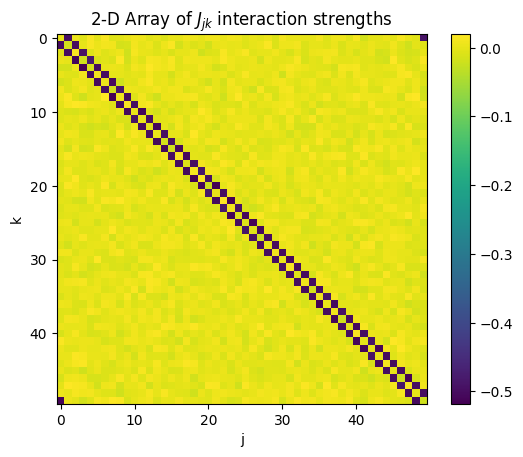

In [ ]:
import matplotlib.pyplot as plt
for name, param in model.named_parameters():
    if name == '0.weight':
        weight_tensor = param.data
array_2d = weight_tensor.reshape(L, L)

# Plot
plt.imshow(array_2d, cmap='viridis')
plt.colorbar()
plt.title('2-D Array of $J_{jk}$ interaction strengths')
plt.xlabel('j')
plt.ylabel('k')
plt.show()

Here are things for you to explore:
- Does changing the learning rate help or hurt the convergence? What is the maximum useful learning rate? Does it depend on the number of spin states?
- What if the interaction strength were doubled in the Ising model? Create a new dataset with that change and see if your model can learn the new interaction strength.
- Could you use the cross-entropy loss function here? Why or why not?

# Collider dataset example

One of the challenges for machine learning generally, and deep learning specifically, is obtaining a large labeled training dataset.
These large datasets are the key to fully fitting a complex deep learning model to data.
If there are not enough data points then the model will be *overfit* to the small training data sample.

Collider physics experiments generate huge particle physics datasets because of the high collision rate.
Each input data point vector $\vec{v}^i$ represents a single particle collision.
The components of the data point $\vec{v}^i_j$ represent features of the specific collision, like the momenta of the outgoing particles.

## Search for supersymmetry

We will work with the [SUSY dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz), available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.html)
This is a comprehensive repository of useful datasets relevant to ML.
The SUSY dataset was prepared by UC Irvine colleagues from the ATLAS experiment.

Here is the description of the SUSY dataset we will be playing around with for this notebook:
>The data has been produced using Monte Carlo simulations and contains events with two leptons (electrons or muons). In high energy physics experiments, such as the ATLAS and CMS detectors at the CERN LHC, one major hope is the discovery of new particles. To accomplish this task, physicists attempt to sift through data events and classify them as either a signal of some new physics process or particle, or instead a background event from understood Standard Model processes. Unfortunately we will never know for sure what underlying physical process happened (the only information to which we have access are the final state particles). However, we can attempt to define parts of phase space that will have a high percentage of signal events. Typically this is done by using a series of simple requirements on the kinematic quantities of the final state particles, for example having one or more leptons with large amounts of momentum that is transverse to the beam line ($p_{T}$).

Here instead we will use logistic regression in order to attempt to find out the relative probability that an event is from a signal or a background event and rather than using the kinematic quantities of final state particles directly we will use the output of our logistic regression to define a part of phase space that is enriched in signal events.

The dataset we are using has values of 18 kinematic variables ("features") for each the event. The first 8 features are direct measurements of final state particles, in this case the $p_{T}$, pseudo-rapidity ($\eta$), and azimuthal angle ($\phi$) of two leptons in the event and the amount of missing transverse momentum (MET) together with its azimuthal angle. The last ten features are functions of the first 8 features; these are high-level features derived by physicists to help discriminate between the two classes. You can think of them as physicists attempt to use non-linear functions to classify signal and background events and they have been developed with a lot of deep thinking on the part of physicist.

The dataset consists of 5 million events We will use the first 1,000,000 for training the model.

## Classification task

The training data consists of a set of features and discrete labels. This type of data is called categorical data (the data comes in different categories).

In the SUSY dataset, the goal is to decide whether a data point represents signal "potential collision"- labeled 1, or "background"(Standard Model processes which produce final states with similar constituents as SUSY processes) - labeled 0. This is done by looking at the 18 input features - the first 8 of which are "low-level" features that can be directly measured and the last 10 features are "higher-order" features constructed using physics intuition. In more detail:
>The first column is the class label (1 for signal, 0 for background), followed by the 18 features (8 low-level features then 10 high-level features):: lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)

Our goal will be to use either the first 8 features or the full 18 features to predict whether an event is signal or background.

The cross-entropy loss function is the right choice for this kind of classification task.



## Importing the data set

The dataset is large (how large?), so we will use a custom class to define the PyTorch tensors.
The advantage is that we don't need to download the file, convert it in memory, and then copy the data to a tensor.
All of that happens in one pass inside `CSVDataset`.
We added a parameter to limit the size of the dataset while we are debugging; otherwise you will get the full 5 million events!

The AI agents are very very good at helping you figure out how to import data and reshape it as needed for training.

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class CSVDataset(Dataset):
    def __init__(self, csv_file, max_samples=None):
        self.data = pd.read_csv(csv_file)
        if max_samples:
            self.data = self.data.iloc[:max_samples]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = torch.tensor(row.iloc[1:].values, dtype=torch.float32)
        label = torch.tensor(row.iloc[0], dtype=torch.float32)
        return features, label

# Use it with DataLoader
dataset = CSVDataset('https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz', 10000)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

How would you change the CSVDataset function to load just the first 8 input features instead of all of them?

It is good to check the data format for one input vector before creating the model.
Here we look at the input features and sample label for the first record (first collision event) in the dataset.

In [ ]:
print(len(dataset))

# Get a single batch
batch_features, batch_labels = next(iter(dataloader))

print(f"Features shape: {batch_features.shape}")
print(f"Labels shape: {batch_labels.shape}")
print(f"\nFirst sample features:\n{batch_features[0]}")
print(f"\nFirst sample label: {batch_labels[0]}")

10000
Features shape: torch.Size([32, 18])
Labels shape: torch.Size([32])

First sample features:
tensor([ 0.5723,  1.1521, -1.3905,  0.5922,  0.9927,  1.2688,  1.3211, -0.0082,
         1.9831, -1.0000,  0.4850,  1.1641,  2.1300,  2.2948,  0.6292,  1.7405,
         1.5081,  0.4175])

First sample label: 0.0


Now we are ready to create a neural network model to learn the relationship between the input features and the sample label.

- What has to change in the code if we change the number of input features?
- Why is there only one output in this model?
- What is a reasonable number of nodes in the hidden layer?
- How would you add hidden layers to the model?
- What loss function is chosen here, and why?

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(18, 30),
    nn.Sigmoid(),
    nn.Linear(30, 1),
    nn.Sigmoid()
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 500
# Training loop
for epoch in range(num_epochs):
    for batch_features, batch_labels in dataloader:
        # Forward pass
        predictions = model(batch_features)
        # Reshape batch_labels to match predictions
        loss = criterion(predictions, batch_labels.unsqueeze(1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/500], Loss: 0.7182
Epoch [2/500], Loss: 0.6714
Epoch [3/500], Loss: 0.6309
Epoch [4/500], Loss: 0.6419
Epoch [5/500], Loss: 0.6218
Epoch [6/500], Loss: 0.6571
Epoch [7/500], Loss: 0.6353
Epoch [8/500], Loss: 0.5878
Epoch [9/500], Loss: 0.6500
Epoch [10/500], Loss: 0.5950
Epoch [11/500], Loss: 0.5991
Epoch [12/500], Loss: 0.5835
Epoch [13/500], Loss: 0.6368
Epoch [14/500], Loss: 0.6208
Epoch [15/500], Loss: 0.6509
Epoch [16/500], Loss: 0.5146
Epoch [17/500], Loss: 0.6671
Epoch [18/500], Loss: 0.6572
Epoch [19/500], Loss: 0.6157
Epoch [20/500], Loss: 0.6415
Epoch [21/500], Loss: 0.5778
Epoch [22/500], Loss: 0.6032
Epoch [23/500], Loss: 0.7304
Epoch [24/500], Loss: 0.5816
Epoch [25/500], Loss: 0.6135
Epoch [26/500], Loss: 0.6478
Epoch [27/500], Loss: 0.6528
Epoch [28/500], Loss: 0.5445
Epoch [29/500], Loss: 0.5865
Epoch [30/500], Loss: 0.5762
Epoch [31/500], Loss: 0.5805
Epoch [32/500], Loss: 0.6362
Epoch [33/500], Loss: 0.5123
Epoch [34/500], Loss: 0.6050
Epoch [35/500], Loss: 0

KeyboardInterrupt: 

Make sure you understand each line in the training loop over epochs. If something is not clear, try asking your AI agent to explain the line to you.

- Does the loss decrease smoothly with the number of training epochs?
- What explains the behavior?

If it is not smooth, try some ideas to make it more smooth and decrease the overall loss value at the end of the training.

Now we will look at the results of the classification by comparing the NN prediction with the correct label. What has the neural network learned?

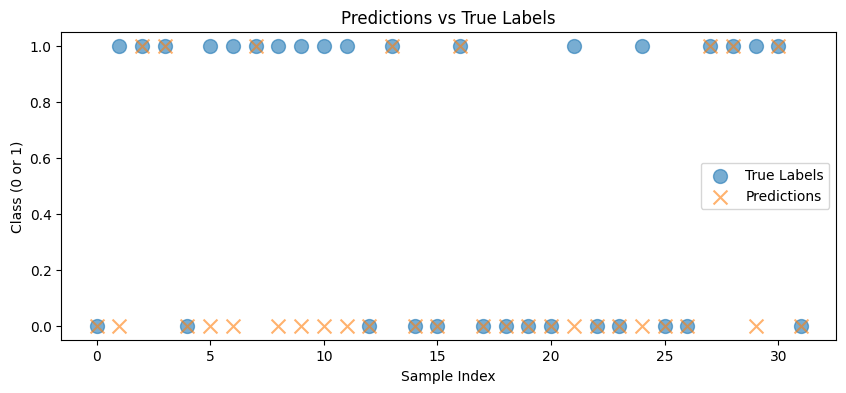

In [ ]:
import matplotlib.pyplot as plt

# After training, evaluate on a batch
model.eval()
with torch.no_grad():
    sample_features, sample_labels = next(iter(dataloader))
    outputs = model(sample_features)
    predictions = (outputs > 0.5).float()

# Plot
plt.figure(figsize=(10, 4))
plt.scatter(range(len(sample_labels)), sample_labels.numpy(),
            label='True Labels', alpha=0.6, s=100)
plt.scatter(range(len(predictions)), predictions.numpy(),
            label='Predictions', alpha=0.6, marker='x', s=100)
plt.xlabel('Sample Index')
plt.ylabel('Class (0 or 1)')
plt.legend()
plt.title('Predictions vs True Labels')
plt.show()

Now we will look at a summary plot of the training results.
The plot below is called the *confusion matrix*.
Which cells represent confusion on the part of the algorithm?

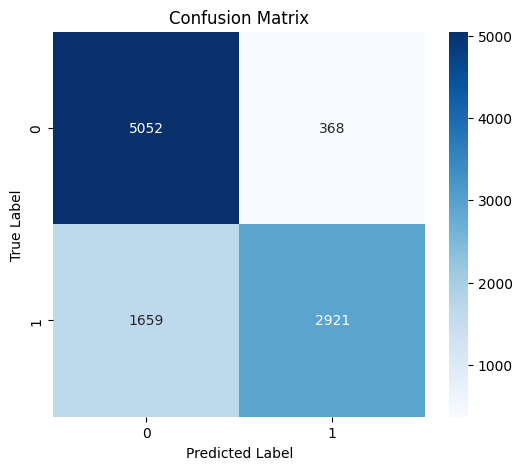

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_features, batch_labels in dataloader:
        outputs = model(batch_features)
        predictions = (outputs > 0.5).float()
        all_predictions.extend(predictions.numpy())
        all_labels.extend(batch_labels.numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

It would be nice to minimize the number of events in the confusion cells, where the NN has misclassified the collision event.

Do you have some ideas on how to improve the model?